In [1]:
import pandas as pd
import mplfinance as mpf
import torch
import pandas as pd
from src.models.forecast.lstm_module import LSTMForecastModule
from src.data.openbb_datamodule import OpenBBDataModule
import numpy as np
import matplotlib.pyplot as plt


/home/itachi/Programming/Utokyo/LabSuzumura/StockProject/alphadl/venv/lib/python3.10/site-packages/pytorch_forecasting/models/base_model.py:27: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from tqdm.autonotebook import tqdm


In [2]:
def calculate_and_normalize_returns(data, sequence_length):
    """
    Calculate and normalize returns for the given data.

    Parameters:
    - data (pd.DataFrame): The data from which to calculate returns.
    - sequence_length (int): The length of the sequence window for model input.

    Returns:
    - returns_tensor (torch.FloatTensor): A tensor of normalized returns.
    """
    print("Calculating and normalizing returns")
    close_prices = data["Close"].values
    returns = []

    # Calculate the 1-day return ratio
    for i in range(sequence_length, len(close_prices)):
        ret = (close_prices[i] - close_prices[i - 1]) / close_prices[i - 1]
        returns.append(ret)

    # Convert list to numpy array
    returns = np.array(returns)

    # Apply z-score normalization to returns
    return_mean = returns.mean()
    return_std = returns.std()
    normalized_returns = (returns - return_mean) / return_std

    # Convert numpy array to tensor
    returns_tensor = torch.FloatTensor(normalized_returns).unsqueeze(-1)

    return returns_tensor


In [24]:
ticker = "AAPL"
test_df_raw = pd.read_csv(f"./data/US/1m/sp500/{ticker}.csv")
test_df_raw.columns = test_df_raw.columns.str.capitalize()
test_df_raw['Date'] = pd.to_datetime(test_df_raw['Date'])
test_df_raw.set_index('Date', inplace=True)
print(test_df_raw.shape)
test_df_raw

(84060, 6)


,Open,High,Low,Close,Volume,Ticker
Date,,,,,,
2024-01-02 09:30:00,187.150,188.05,186.35,187.8300,3234668,AAPL
2024-01-02 09:31:00,187.830,188.12,187.63,187.7650,809707,AAPL
2024-01-02 09:32:00,187.770,188.44,187.73,188.2984,687086,AAPL
2024-01-02 09:33:00,188.305,188.31,187.81,188.1600,485275,AAPL
2024-01-02 09:34:00,188.150,188.15,187.67,187.7300,415948,AAPL
...,...,...,...,...,...,...
2024-11-07 15:55:00,226.840,227.46,226.83,227.1200,460552,AAPL
2024-11-07 15:56:00,227.110,227.25,227.11,227.1800,161775,AAPL
2024-11-07 15:57:00,227.190,227.19,227.05,227.1300,219820,AAPL


In [25]:
# Drop non-numeric columns before resampling
numeric_df = test_df_raw.drop(columns=['Ticker'])

# Resample to 5-minute average
test_df = numeric_df.resample('5T').mean()

# Drop NaN values before resampling
test_df.dropna(inplace=True)

print(test_df.shape)
test_df

(16812, 5)


/tmp/ipykernel_135867/1108322838.py:5: FutureWarning: 'T' is deprecated and will be removed in a future version, please use 'min' instead.
  test_df = numeric_df.resample('5T').mean()


,Open,High,Low,Close,Volume
Date,,,,,
2024-01-02 09:30:00,187.84100,188.21400,187.43800,187.95668,1126536.8
2024-01-02 09:35:00,187.68696,187.82900,187.47400,187.63900,365477.2
2024-01-02 09:40:00,186.82180,186.93808,186.49100,186.56600,438296.0
2024-01-02 09:45:00,186.42400,186.62400,186.20894,186.38880,346583.8
2024-01-02 09:50:00,186.26224,186.48800,186.16900,186.29836,297503.8
...,...,...,...,...,...
2024-11-07 15:35:00,227.46800,227.48600,227.42200,227.45800,65004.6
2024-11-07 15:40:00,227.56000,227.62400,227.52200,227.60400,66432.8
2024-11-07 15:45:00,227.77400,227.82200,227.72000,227.78800,103025.4


/home/itachi/Programming/Utokyo/LabSuzumura/StockProject/alphadl/venv/lib/python3.10/site-packages/mplfinance/_arg_validators.py:84: UserWarning: 


            POSSIBLE TO SEE DETAILS (Candles, Ohlc-Bars, Etc.)
   For more information see:
   - https://github.com/matplotlib/mplfinance/wiki/Plotting-Too-Much-Data
   
   TO SILENCE THIS WARNING, set `type='line'` in `mpf.plot()`
   OR set kwarg `warn_too_much_data=N` where N is an integer 
   LARGER than the number of data points you want to plot.

  warnings.warn('\n\n ================================================================= '+


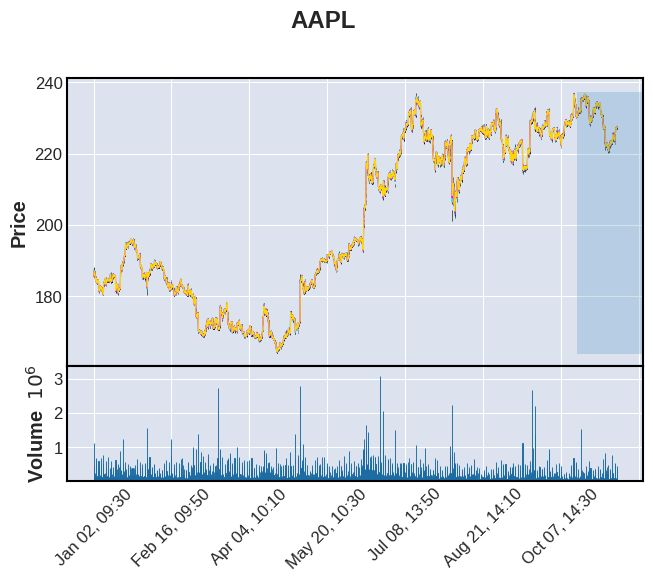

In [9]:
ref_time = '2024-11-06 20:30:00'
mpf.plot(
    test_df, 
    type="candle", 
    mav=(3, 6, 9), 
    volume=True, 
    vlines=dict(vlines=ref_time, linewidths=50,alpha=0.2),
    title=ticker,
)

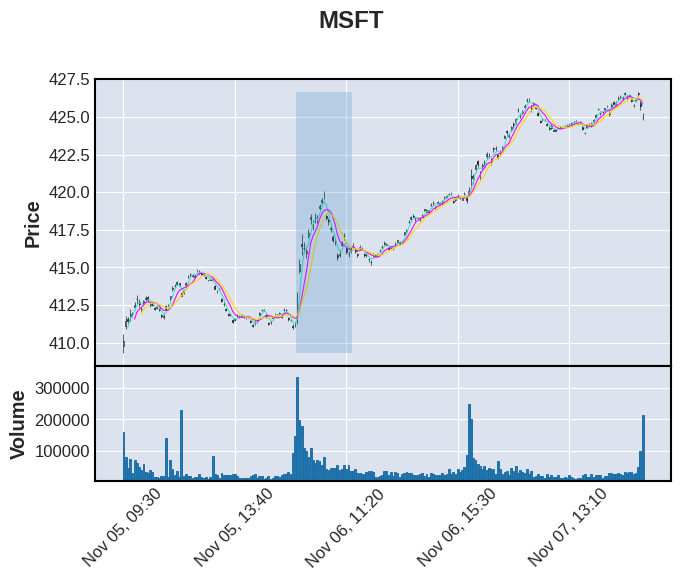

In [18]:
# Assuming test_df is your resampled DataFrame
# Filter data between 2024-11-05 and 2024-11-07
filtered_df = test_df.loc['2024-11-05':'2024-11-07']

# Define the reference time
ref_time = '2024-11-06 10:30:00'

# Plotting
mpf.plot(
    filtered_df, 
    type="candle", 
    mav=(3, 6, 9), 
    volume=True, 
    vlines=dict(vlines=ref_time, linewidths=40, alpha=0.2),
    title="MSFT",  # Replace with your ticker variable if needed
)

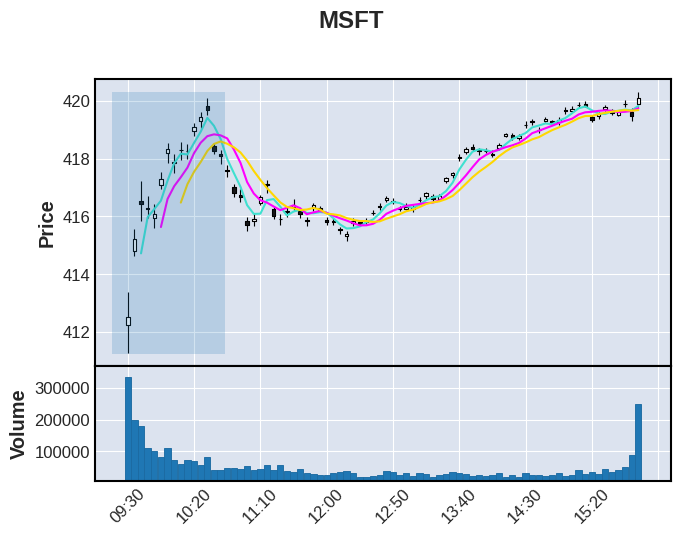

In [23]:
# Assuming test_df is your resampled DataFrame
# Filter data between 2024-11-05 and 2024-11-07
filtered_df = test_df.loc['2024-11-06':'2024-11-06']

# Define the reference time
ref_time = '2024-11-06 10:00:00'

# Plotting
mpf.plot(
    filtered_df, 
    type="candle", 
    mav=(3, 6, 9), 
    volume=True, 
    vlines=dict(vlines=ref_time, linewidths=80, alpha=0.2),
    title="MSFT",  # Replace with your ticker variable if needed
)

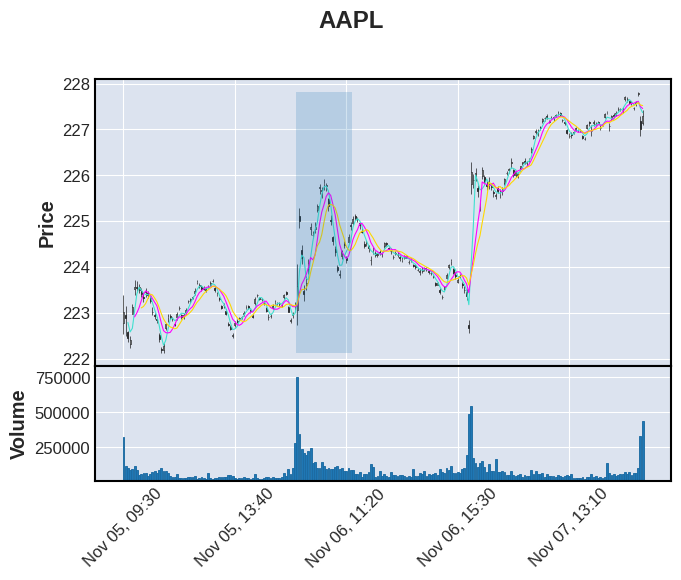

In [15]:
# Assuming test_df is your resampled DataFrame
# Filter data between 2024-11-05 and 2024-11-07
filtered_df = test_df.loc['2024-11-05':'2024-11-07']

# Define the reference time
ref_time = '2024-11-06 10:30:00'

# Plotting
mpf.plot(
    filtered_df, 
    type="candle", 
    mav=(3, 6, 9), 
    volume=True, 
    vlines=dict(vlines=ref_time, linewidths=40, alpha=0.2),
    title="AAPL",  # Replace with your ticker variable if needed
)

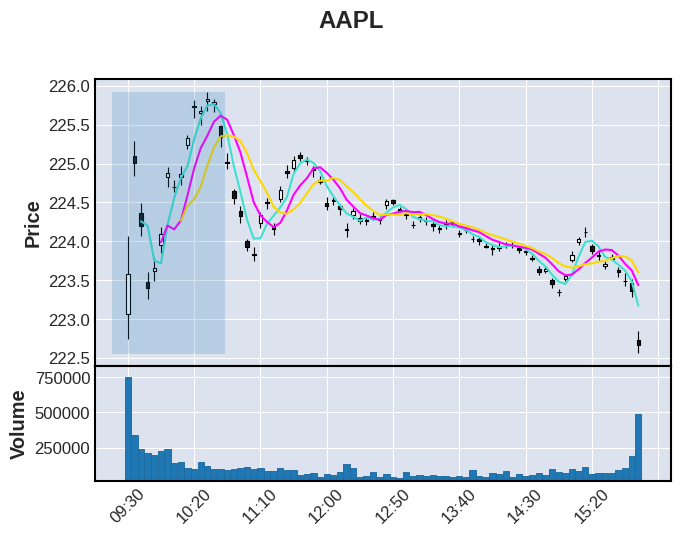

In [27]:
# Assuming test_df is your resampled DataFrame
# Filter data between 2024-11-05 and 2024-11-07
filtered_df = test_df.loc['2024-11-06':'2024-11-06']

# Define the reference time
ref_time = '2024-11-06 10:00:00'

# Plotting
mpf.plot(
    filtered_df, 
    type="candle", 
    mav=(3, 6, 9), 
    volume=True, 
    vlines=dict(vlines=ref_time, linewidths=80, alpha=0.2),
    title="AAPL",  # Replace with your ticker variable if needed
)

In [6]:
# Calculate and normalize returns
sequence_length = 30
normalized_returns = calculate_and_normalize_returns(test_df_raw, sequence_length)
print(normalized_returns.shape)

Calculating and normalizing returns
torch.Size([1140, 1])


In [7]:
# Determine the device to use (GPU if available, otherwise CPU)
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

data_module = OpenBBDataModule(
    ticker='AAPL',
    train_date=['2024-09-01', '2024-10-29'],
    val_date=['2024-10-29', '2024-11-05'],
    test_date=['2024-11-05', '2024-11-07'],
    interval='1m',
    market='US',
    sequence_length=30,
    batch_size=64,
    cache_dir='./data',
    use_cache=True,
    provider='fmp',
    openbb_output_type='dataframe'
)

# Prepare the data
data_module.prepare_data()

# Prepare the data module
data_module.setup()

# Get the test sequences
test_sequences, _ = data_module.test_sequences, data_module.test_targets


INFO:src.data.openbb_datamodule:Loading data from cache files in: ./data/US/1m/AAPL
INFO:src.data.openbb_datamodule:Setting up data sequences
INFO:src.data.openbb_datamodule:Train data shape: (21060, 5)
INFO:src.data.openbb_datamodule:Val data shape: (2340, 5)
INFO:src.data.openbb_datamodule:Test data shape: (1170, 5)
INFO:src.data.openbb_datamodule:Preparing sequences
INFO:src.data.openbb_datamodule:Preparing sequences
INFO:src.data.openbb_datamodule:Preparing sequences


In [8]:
# Get the test sequences and move them to the correct device
test_sequences, _ = data_module.test_sequences, data_module.test_targets
test_sequences = test_sequences.to(device)


In [10]:
# Load the model and move it to the correct device
# ckt_path = "./logs/train/runs/lstm_appl_nov/2024-11-29_05-19-23/checkpoints/epoch_000.ckpt"
ckt_path = "./logs/train/runs/lstm_appl_nov/2024-11-29_06-07-42/checkpoints/epoch_002.ckpt"
model = LSTMForecastModule.load_from_checkpoint(ckt_path)
model.to(device)
model.eval()

# Make predictions
with torch.no_grad():
    predictions = model(test_sequences).squeeze().cpu().numpy()

In [11]:
print(len(predictions))
predictions

1139


array([-1.9297004e-05,  1.0713935e-05,  3.1471252e-05, ...,
        8.3856285e-05,  1.4630705e-04,  2.0729005e-04], dtype=float32)

In [12]:
test_df_raw.iloc[sequence_length:].shape

(1140, 5)

In [13]:
# Align normalized returns with dates
return_dates = test_df_raw.index[sequence_length:]  # Returns start from the second date
normalized_returns_df = pd.DataFrame(data=normalized_returns.numpy(), index=return_dates, columns=['Normalized_Return'])
normalized_returns_df = normalized_returns_df.iloc[1:]
print(normalized_returns_df.shape)
normalized_returns_df.head()

(1139, 1)


,Normalized_Return
Date,
2024-11-05 10:01:00,0.728774
2024-11-05 10:02:00,-1.927173
2024-11-05 10:03:00,0.366783
2024-11-05 10:04:00,-0.358401
2024-11-05 10:05:00,0.427223


In [16]:
# Align predictions with dates
prediction_dates = test_df_raw.index[sequence_length + 1:]  # Predictions start from the 31st date
predictions_df = pd.DataFrame(data=predictions, index=prediction_dates, columns=['Close'])
print(predictions_df.shape)
predictions_df.head()



(1139, 1)


,Close
Date,
2024-11-05 10:01:00,-0.000019
2024-11-05 10:02:00,0.000011
2024-11-05 10:03:00,0.000031
2024-11-05 10:04:00,-0.000004
2024-11-05 10:05:00,0.000012


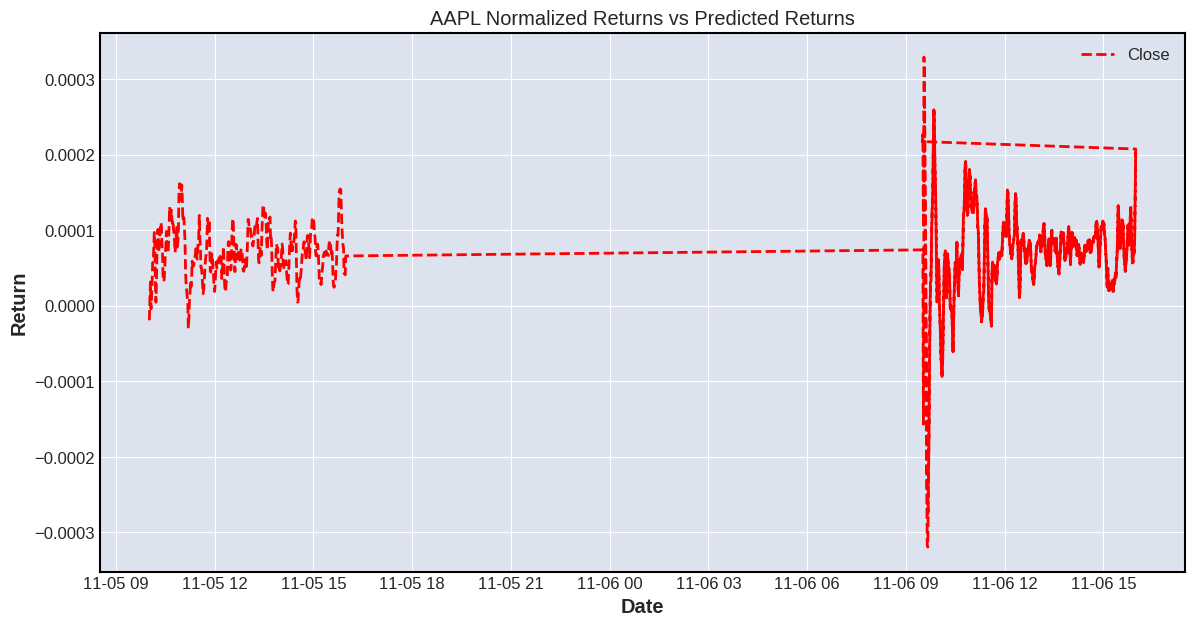

In [19]:
# Plot the normalized returns and predictions
plt.figure(figsize=(14, 7))
plt.plot(
    predictions_df.index,
    predictions_df["Close"],
    label="Close",
    color="red",
    linestyle="--",
)
plt.title(f"{ticker} Normalized Returns vs Predicted Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()

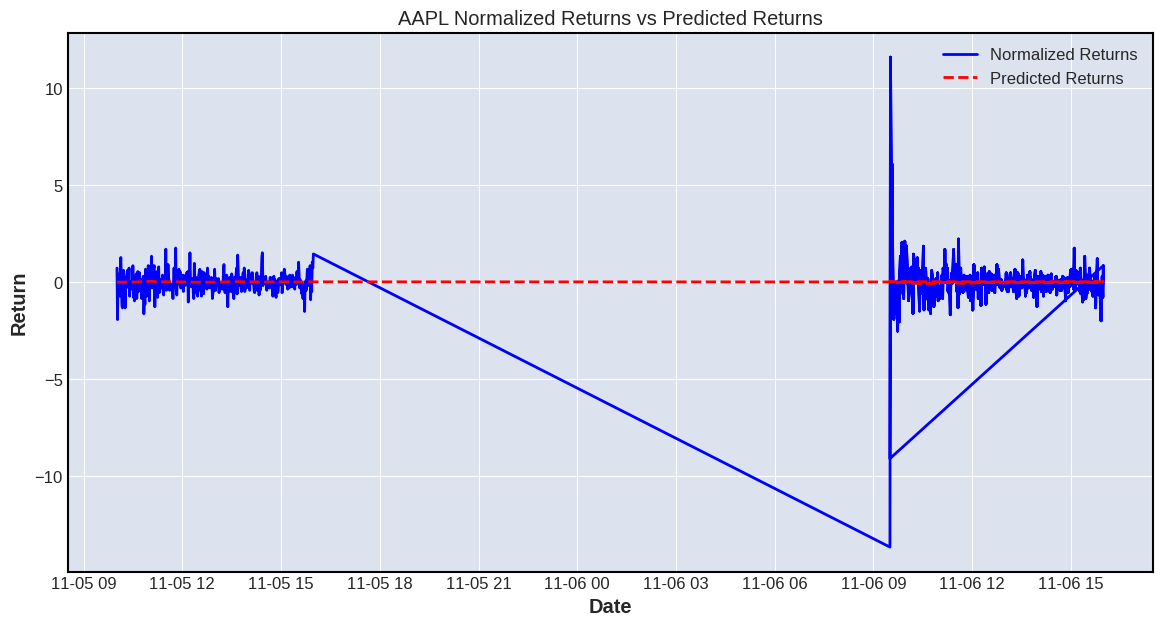

In [72]:
# Plot the normalized returns and predictions
plt.figure(figsize=(14, 7))
plt.plot(
    normalized_returns_df.index,
    normalized_returns_df["Normalized_Return"],
    label="Normalized Returns",
    color="blue",
)
plt.plot(
    predictions_df.index,
    predictions_df["Predicted_Return"],
    label="Predicted Returns",
    color="red",
    linestyle="--",
)
plt.title(f"{ticker} Normalized Returns vs Predicted Returns")
plt.xlabel("Date")
plt.ylabel("Return")
plt.legend()
plt.grid(True)
plt.show()